In [1]:
import torch
import torch.nn as nn
from PytorchNetwork import TestNetwork
from PytorchNetwork import NetworkSlicer
import math, os, shutil, time
from torch import optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
np.random.seed(123)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

def sinsin(x,y):
    return np.sin(x)+np.sin(y)

def createData(f,size=1024,maxrange=5):
    l = []
    samplesPerDim = int(np.sqrt(size))
    step = maxrange/(samplesPerDim-1)
    for x in range(0,samplesPerDim):
        for y in range(0,samplesPerDim):
            l.append({'x':[x*step,y*step],'y':f(x*step,y*step)})
    return l

def getRandomVector(model,length):
    w = list(np.array(model.getWeights())*0)
    b = list(np.array(model.getBiases())*0)
    wb = w+b
    for i in range(len(wb)):
        wb[i] = np.random.normal()
    wb = wb/np.linalg.norm(wb)*length
    return {'weights':list(wb[:len(w)]),'biases':list(wb[len(w):])}

In [3]:
#Generate training and test data
trainingData = createData(sinsin,1024)
testData = createData(sinsin,1024)

#Initialize model
neurons = 1
layersShape = [2,neurons,neurons,1]
model = TestNetwork(layersShape=layersShape)
model.device = torch.device("cpu")
model.setActivationFunction("sigmoid")
model.setLossFunction("mse")

#Initialize slicer
slicer = NetworkSlicer(model,trainingData,testData)
#print("New network created:",model)

#Computational settings
slicer.minX = -10
slicer.maxX = 10
numOfSamplingPoints = 200
sampleSize = 101

#Create random weights
initVec = getRandomVector(model,1.0)
#Create trained weights
tVec = slicer.getOptimizedFocusPoint(epochs=10000,lossThreshold=0.01,maxSeconds=10,bs=0,optimizerType="adam",initialWeights=None,initialBiases=None,learningRate=None,weightDecay=0)[0]
#tVec=initVec
w = tVec['weights']
b = tVec['biases']
print("loss",slicer.computeLoss(w,b))
dim = len(w)+len(b)
charts = [[] for i in range(dim)]
samplingVectors = slicer.getRandomPoints(centerFP=tVec,quantity=numOfSamplingPoints,samplingMethod="uniform",radius=1)

data = [slicer.addFocusPoint(w,b,sampleSize)]
for s in samplingVectors:
    data.append(slicer.addFocusPoint(s['weights'],s['biases'],sampleSize))

for e in data:
    slices = np.array(e['slices'])
    for d in range(dim):
        s = [slices[d][:,0],slices[d][:,1]]
        charts[d].append(s)

2.6.0
loss 0.3078380823135376


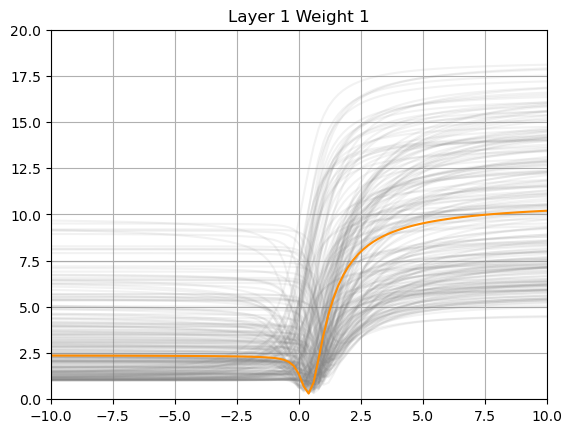

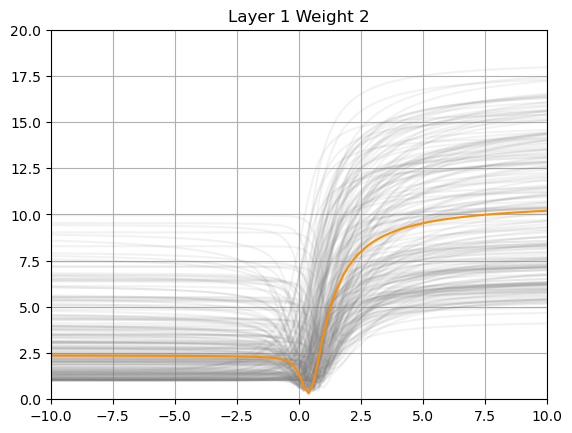

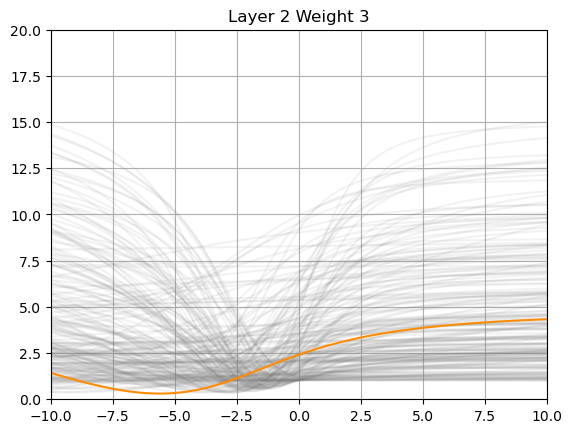

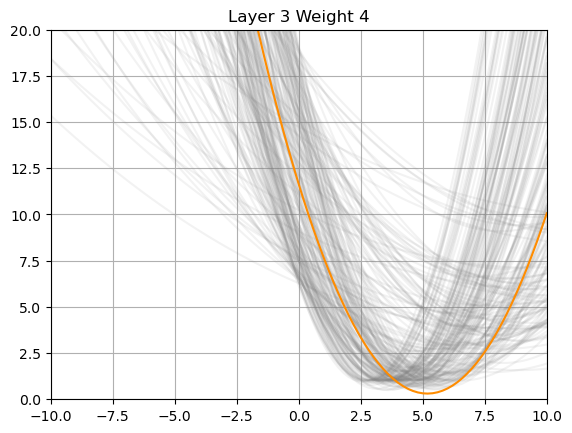

In [4]:
#Visual settings
sliceOpacity = 0.1
minY = 0
maxY = 20
minX = -10
maxX = 10

#Plot weights
for l in range(len(model.weightsPerLayer)-1):
    for d in range(model.weightsPerLayer[l],model.weightsPerLayer[l+1]):
        e = charts[d]
        #Random vectors
        for i in range(1,len(e)):
            plt.plot(e[i][0],e[i][1],color="grey",alpha=sliceOpacity)
        #Center vector
        plt.plot(e[0][0],e[0][1],color="darkorange",alpha=1.0)
        plt.ylim(minY,maxY)
        plt.xlim(minX,maxX)
        plt.grid()
        plt.title("Layer "+str(l+1)+" Weight "+str(d+1))
        plt.show()

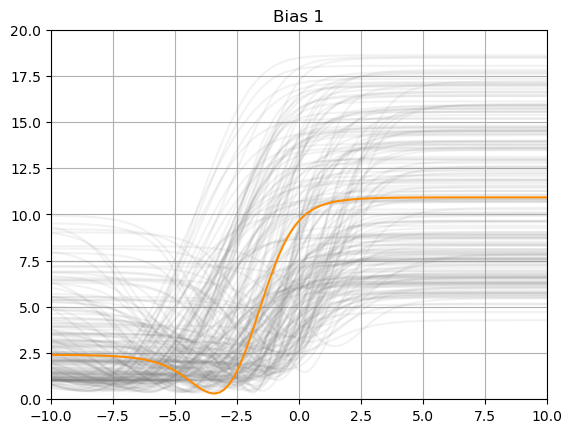

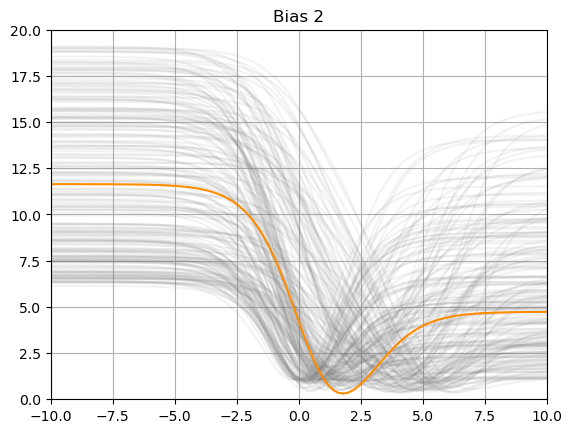

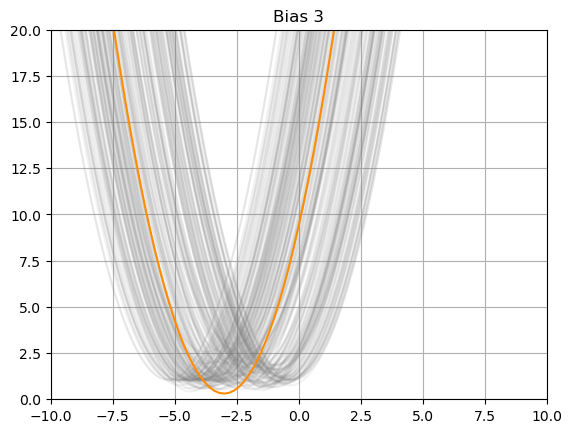

In [5]:
#Plot biases
for d in range(len(w),dim):
    e = charts[d]
    #Random vectors
    for i in range(1,len(e)):
        plt.plot(e[i][0],e[i][1],color="grey",alpha=sliceOpacity)
    #Center vector
    plt.plot(e[0][0],e[0][1],color="darkorange",alpha=1.0)
    plt.ylim(minY,maxY)
    plt.xlim(slicer.minX,slicer.maxX)
    plt.grid()
    plt.title("Bias "+str(d-len(w)+1))
    plt.show()

In [6]:
print("Init:")
print("L2",np.linalg.norm(initVec['weights']+initVec['biases']))
print("Loss",slicer.computeLoss(initVec['weights'],initVec['biases']))
print(initVec)

print("\nTrained:")
print("L2",np.linalg.norm(tVec['weights']+tVec['biases']))
print("Loss",slicer.computeLoss(tVec['weights'],tVec['biases']))

print(tVec)

Init:
L2 1.0
Loss 2.3697099685668945
{'weights': [np.float64(-0.2957662032677851), np.float64(0.27171403899782476), np.float64(0.07709388047905515), np.float64(-0.4103707717739669)], 'biases': [np.float64(-0.15763225466769534), np.float64(0.4499128092280729), np.float64(-0.6611177910654427)]}

Trained:
L2 9.077294222081193
Loss 0.3078380823135376
{'weights': [0.38967427611351013, 0.38967427611351013, -5.595070838928223, 5.186716079711914], 'biases': [-3.4125943183898926, 1.779667615890503, -3.0122616291046143], 'loss': 0.30783820152282715}


In [7]:
def save(fileName,content):
    f = open(fileName,"w")
    f.write(str(content))
    f.close()

import json
save("targetVector.txt",json.dumps(tVec))
save("samplingVectors.txt",json.dumps(samplingVectors))

In [8]:
w = initVec['weights']
b = initVec['biases']
print("loss",slicer.computeLoss(w,b))
dim = len(w)+len(b)
charts = [[] for i in range(dim)]
samplingVectors = slicer.getRandomPoints(centerFP=initVec,quantity=numOfSamplingPoints,samplingMethod="uniform",radius=1)

data = [slicer.addFocusPoint(w,b,sampleSize)]
for s in samplingVectors:
    data.append(slicer.addFocusPoint(s['weights'],s['biases'],sampleSize))

for e in data:
    slices = np.array(e['slices'])
    for d in range(dim):
        s = [slices[d][:,0],slices[d][:,1]]
        charts[d].append(s)

loss 2.3697099685668945


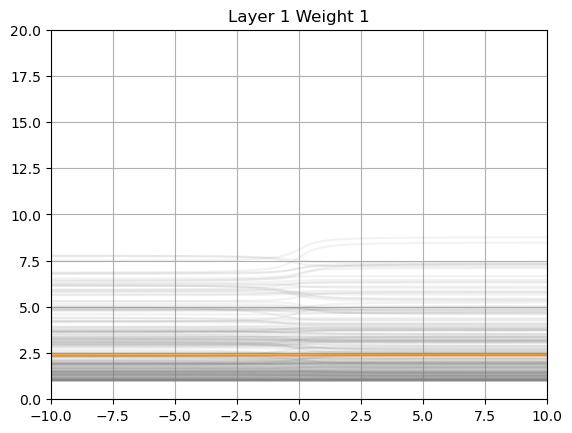

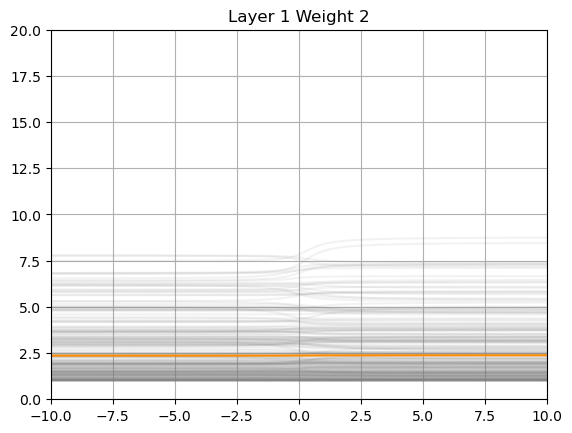

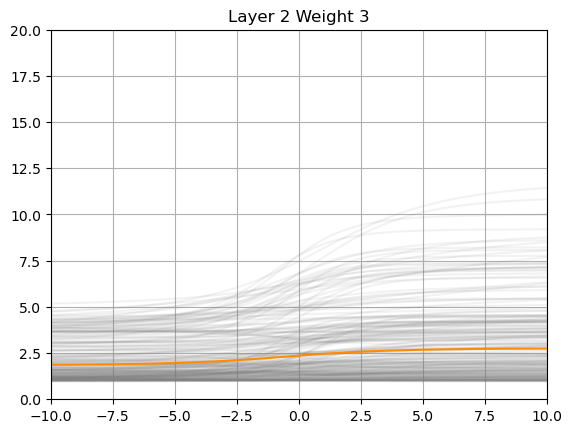

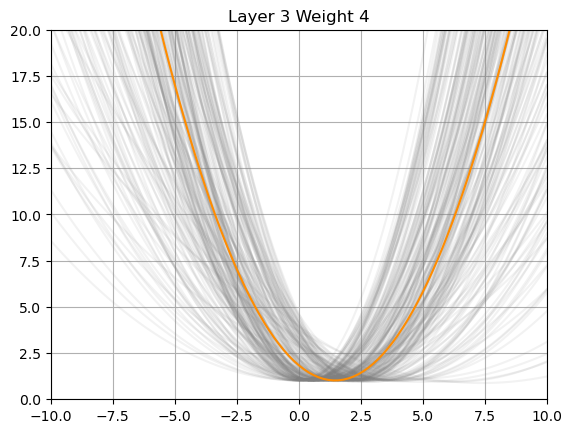

In [9]:
#Visual settings
sliceOpacity = 0.1
minY = 0
maxY = 20
minX = -10
maxX = 10

#Plot weights
for l in range(len(model.weightsPerLayer)-1):
    for d in range(model.weightsPerLayer[l],model.weightsPerLayer[l+1]):
        e = charts[d]
        #Random vectors
        for i in range(1,len(e)):
            plt.plot(e[i][0],e[i][1],color="grey",alpha=sliceOpacity)
        #Center vector
        plt.plot(e[0][0],e[0][1],color="darkorange",alpha=1.0)
        plt.ylim(minY,maxY)
        plt.xlim(minX,maxX)
        plt.grid()
        plt.title("Layer "+str(l+1)+" Weight "+str(d+1))
        plt.show()

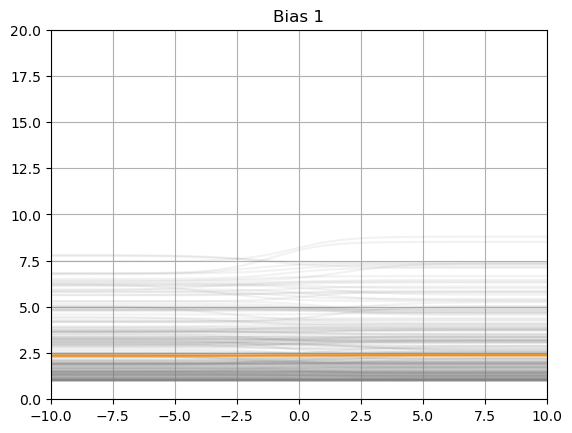

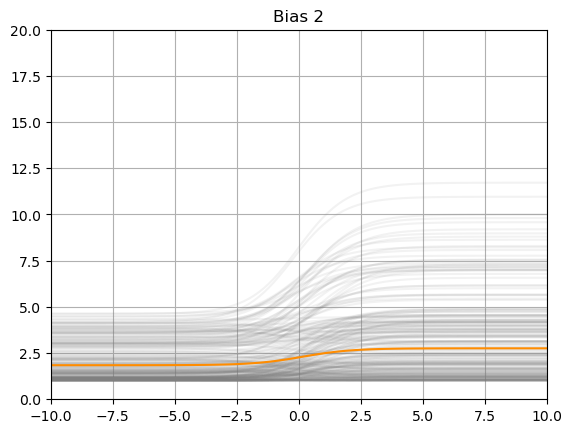

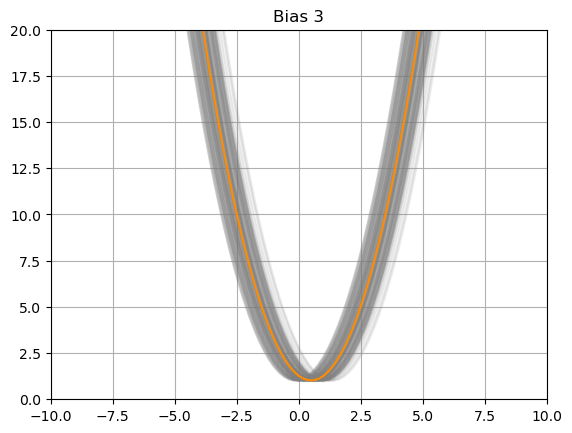

In [10]:
#Plot biases
for d in range(len(w),dim):
    e = charts[d]
    #Random vectors
    for i in range(1,len(e)):
        plt.plot(e[i][0],e[i][1],color="grey",alpha=sliceOpacity)
    #Center vector
    plt.plot(e[0][0],e[0][1],color="darkorange",alpha=1.0)
    plt.ylim(minY,maxY)
    plt.xlim(slicer.minX,slicer.maxX)
    plt.grid()
    plt.title("Bias "+str(d-len(w)+1))
    plt.show()

# Understanding Focus Points vs Center Points

In the original implementation (`NetworkSlicer` class), we used the concept of **focus points** with methods like:
- `addFocusPoint(w, b, sampleSize)` - Creates slices around a point in parameter space
- `getOptimizedFocusPoint(...)` - Finds an optimized point through training
- `getRandomPoints(centerFP, ...)` - Generates random points around a center focus point

In the refactored PySlice library, this concept was renamed to **center points** but maintains the same functionality:
- `compute_slices(center_point, sample_size)` - Same as addFocusPoint
- `get_random_points(center_point, ...)` - Same as getRandomPoints

The naming changed during refactoring, but the core functionality remains the same.